In [46]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm

# Data Loading and Preprocessing
def load_all_folds(base_path):
    folds = ["Fold 1", "Fold 2", "Fold 3"]
    all_images, all_masks, all_types = [], [], []
    
    for fold in folds:
        fold_path = os.path.join(base_path, fold)
        images = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "images.npy"))
        masks = np.load(os.path.join(fold_path, "masks", f"fold{fold[-1]}", "masks.npy"))
        types = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "types.npy"))
        
        all_images.append(images)
        all_masks.append(masks)
        all_types.append(types)
    
    return all_images, all_masks, all_types

base_path = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/raw/H&E"
all_images, all_masks, all_types = load_all_folds(base_path)

def create_train_val_test_split(all_images, all_masks, all_types):
    splits = []
    
    for test_fold in range(3):
        train_val_folds = [i for i in range(3) if i != test_fold]
        
        train_val_images = np.concatenate([all_images[i] for i in train_val_folds])
        train_val_masks = np.concatenate([all_masks[i] for i in train_val_folds])
        train_val_types = np.concatenate([all_types[i] for i in train_val_folds])
        
        num_samples = len(train_val_images)
        num_val = num_samples // 10
        
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        val_indices = indices[:num_val]
        train_indices = indices[num_val:]
        
        split = {
            'train': {
                'images': train_val_images[train_indices],
                'masks': train_val_masks[train_indices],
                'types': train_val_types[train_indices]
            },
            'val': {
                'images': train_val_images[val_indices],
                'masks': train_val_masks[val_indices],
                'types': train_val_types[val_indices]
            },
            'test': {
                'images': all_images[test_fold],
                'masks': all_masks[test_fold],
                'types': all_types[test_fold]
            }
        }
        
        splits.append(split)
    
    return splits

data_splits = create_train_val_test_split(all_images, all_masks, all_types)
print("done")


done


In [108]:
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.segmentation import slic

class CellSegmentationDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, augment=False):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Normalize image to 0-1 range and convert to float32
        image = ((image - image.min()) / (image.max() - image.min())).astype(np.float32)
        
        # Create binary mask from the last channel and convert to float32
        binary_mask = (mask[..., 5] > 0).astype(np.float32)

        if self.augment:
            image, binary_mask = self.apply_augmentation(image, binary_mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            binary_mask = self.mask_transform(binary_mask)

        return image, binary_mask

    def apply_augmentation(self, image, mask):
        # Convert numpy arrays to tensors
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).unsqueeze(0)

        original_size = image.shape[1:]

        # Random 90-degree rotation
        if torch.rand(1) < 0.5:
            k = torch.randint(1, 4, (1,)).item()
            image = torch.rot90(image, k, [1, 2])
            mask = torch.rot90(mask, k, [1, 2])

        # Random horizontal flip
        if torch.rand(1) < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flip
        if torch.rand(1) < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random scaling (downscaling)
        if torch.rand(1) < 0.5:
            scale_factor = torch.FloatTensor(1).uniform_(0.8, 1.0).item()
            new_size = [max(224, int(s * scale_factor)) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Elastic transformation
        if torch.rand(1) < 0.5:
            image = self.elastic_transform(image.permute(1, 2, 0).numpy())
            mask = self.elastic_transform(mask.squeeze().numpy())
            image = torch.from_numpy(image).permute(2, 0, 1)
            mask = torch.from_numpy(mask).unsqueeze(0)

        # Ensure image is large enough for subsequent operations
        if min(image.shape[1:]) < 224:
            scale_factor = 224 / min(image.shape[1:])
            new_size = [int(s * scale_factor) for s in image.shape[1:]]
            image = TF.resize(image, new_size)
            mask = TF.resize(mask, new_size)

        # Blurring
        if torch.rand(1) < 0.5:
            sigma = torch.FloatTensor(1).uniform_(0.1, 2.0).item()
            image = torch.from_numpy(gaussian_filter(image.numpy(), sigma=(0, sigma, sigma)))

        # Gaussian noise
        if torch.rand(1) < 0.5:
            noise = torch.randn_like(image) * 0.1
            image = image + noise
            image = torch.clamp(image, 0, 1)

        # Color jittering
        if torch.rand(1) < 0.5:
            brightness_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            contrast_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            saturation_factor = torch.tensor(1.0).uniform_(0.8, 1.2).item()
            hue_factor = torch.tensor(1.0).uniform_(-0.1, 0.1).item()
            image = TF.adjust_brightness(image, brightness_factor)
            image = TF.adjust_contrast(image, contrast_factor)
            image = TF.adjust_saturation(image, saturation_factor)
            image = TF.adjust_hue(image, hue_factor)

        # SLIC superpixels
        if torch.rand(1) < 0.5:
            image = self.apply_slic(image)

        # Zoom blur
        if torch.rand(1) < 0.5:
            image = self.zoom_blur(image)

        # Random cropping with resizing
        if torch.rand(1) < 0.5:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(224, 224))
            image = TF.crop(image, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)

        # Resize back to original size
        image = TF.resize(image, original_size)
        mask = TF.resize(mask, original_size)

        return image, mask

    def elastic_transform(self, image, alpha=1, sigma=0.1, alpha_affine=0.1):
        """Elastic deformation of images as described in [Simard2003]_."""
        random_state = np.random.RandomState(None)

        shape = image.shape[:2]
        
        # Random affine
        center_square = np.float32(shape) // 2
        square_size = min(shape) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        if image.ndim == 2:
            return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        else:
            result = np.zeros_like(image)
            for i in range(image.shape[2]):
                result[:,:,i] = map_coordinates(image[:,:,i], indices, order=1, mode='reflect').reshape(shape)
            return result

    def apply_slic(self, image):
        image_np = image.numpy().transpose(1, 2, 0)
        segments = slic(image_np, n_segments=100, compactness=10, sigma=1)
        out = np.zeros_like(image_np)
        for i in np.unique(segments):
            mask = segments == i
            out[mask] = np.mean(image_np[mask], axis=0)
        return torch.from_numpy(out.transpose(2, 0, 1))

    def zoom_blur(self, image, max_factor=1.2):
        c, h, w = image.shape
        zoom_factor = torch.FloatTensor(1).uniform_(1, max_factor).item()
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        zoom_image = TF.resize(image, (zh, zw))
        zoom_image = TF.center_crop(zoom_image, (h, w))
        return (image + zoom_image) / 2

# Usage example remains the same

# Usage example
chosen_split = 2

# Define transforms
image_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).permute(2, 0, 1)),
    transforms.Lambda(lambda x: x.float())
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else torch.from_numpy(x).unsqueeze(0)),
    transforms.Lambda(lambda x: x.float())
])

# Create datasets
train_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['train']['images'],
    data_splits[chosen_split]['train']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=True  # Enable augmentation for training set
)

val_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['val']['images'],
    data_splits[chosen_split]['val']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for validation set
)

test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform,
    augment=False  # No augmentation for test set
)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check first item in train_dataset
print("\nChecking first item in train_dataset:")
image, mask = train_dataset[0]
print(f"Final image shape: {image.shape}, dtype: {image.dtype}")
print(f"Final mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Final image min: {image.min().item():.4f}, max: {image.max().item():.4f}")
print(f"Final mask min: {mask.min().item():.4f}, max: {mask.max().item():.4f}")


Checking first item in train_dataset:
Final image shape: torch.Size([3, 256, 256]), dtype: torch.float32
Final mask shape: torch.Size([1, 256, 256]), dtype: torch.float32
Final image min: 0.1963, max: 0.8011
Final mask min: 0.0000, max: 1.0000


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


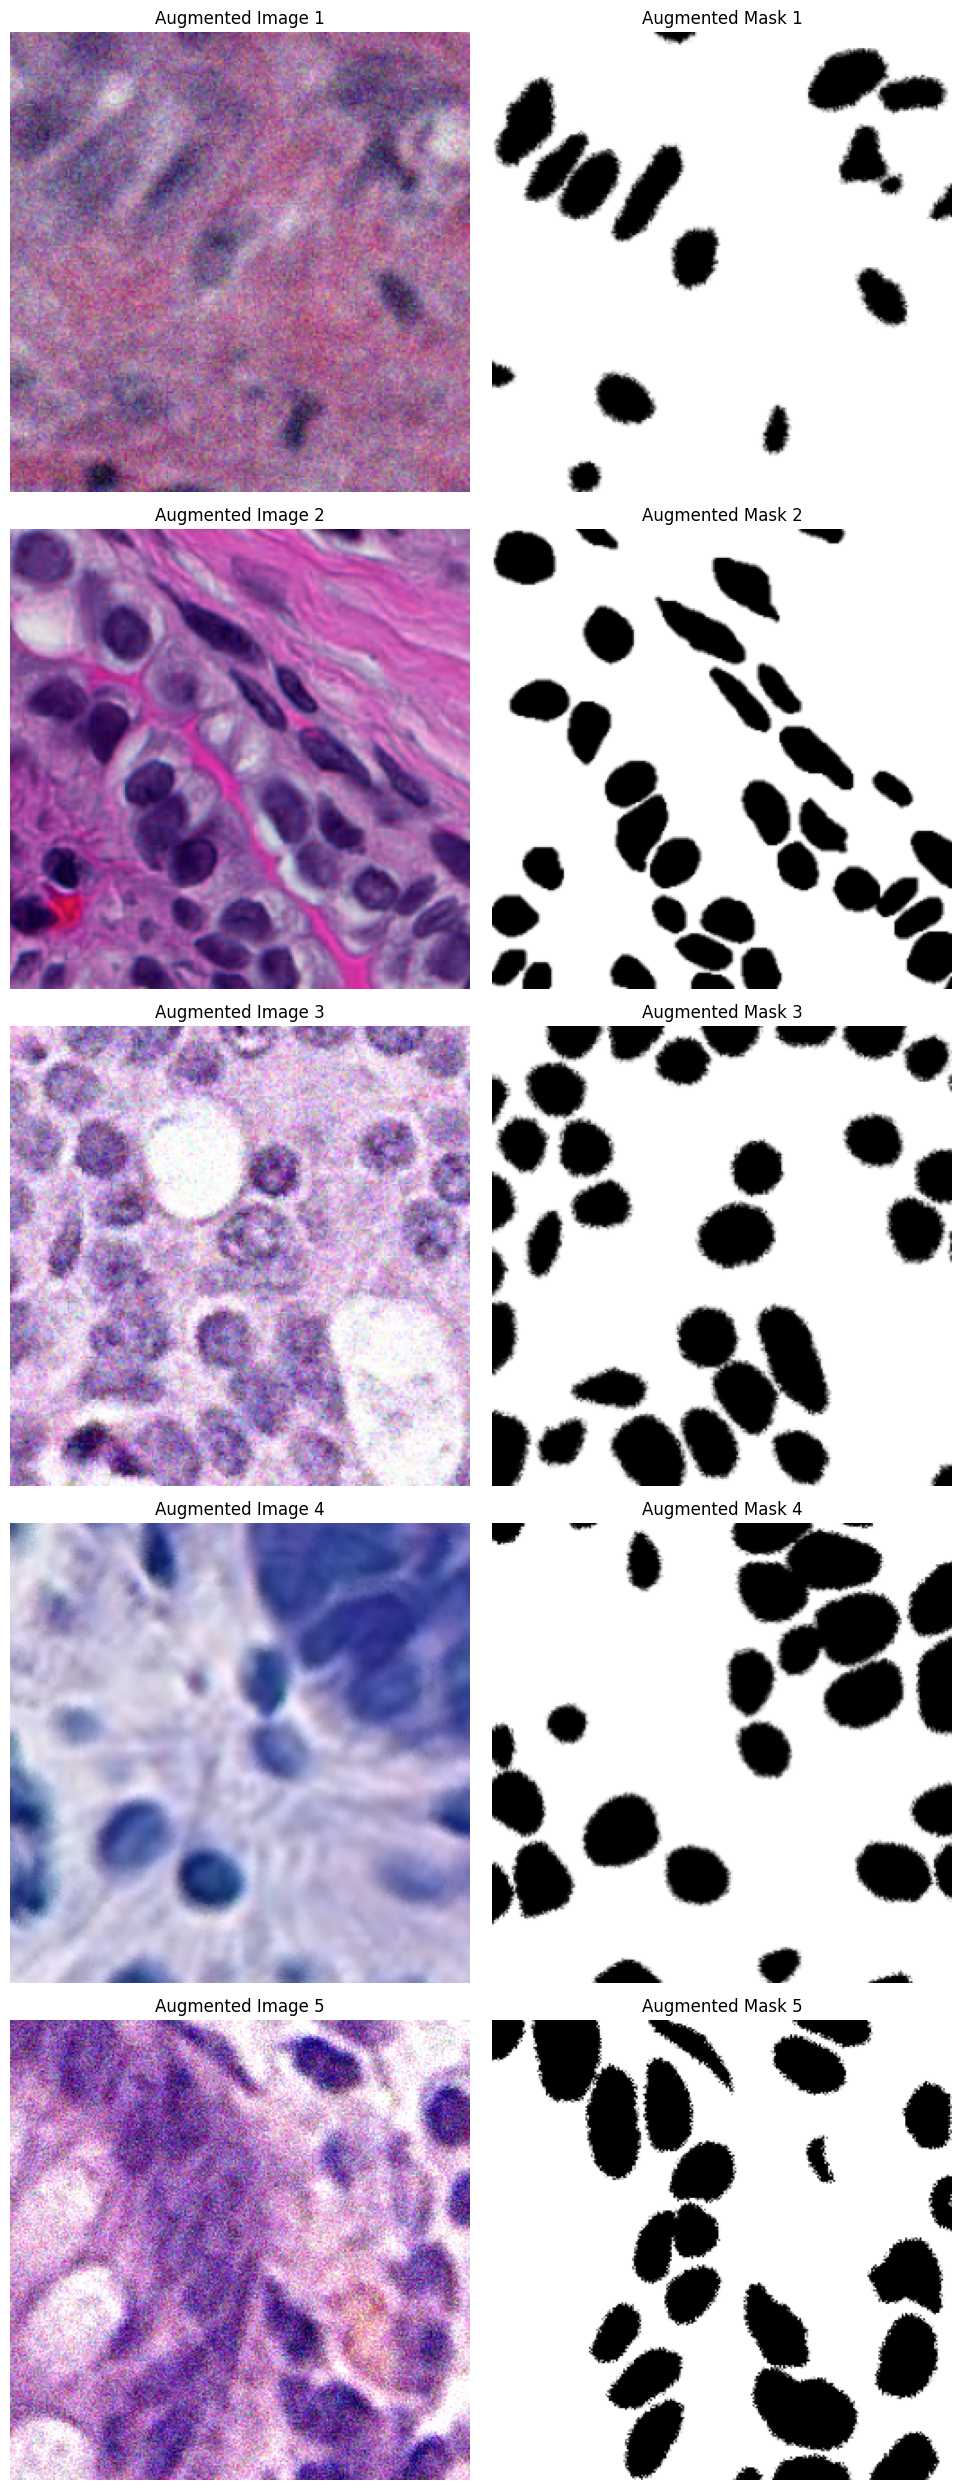

In [109]:
import matplotlib.pyplot as plt

def visualize_augmented_images(dataset, num_samples=5):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.permute(1, 2, 0))
        axs[i, 0].set_title(f"Augmented Image {i+1}")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')
        axs[i, 1].set_title(f"Augmented Mask {i+1}")
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_augmented_images(train_dataset)

## Data visualization

Visualizing first sample from training dataset:
Original image - min: 10.0, max: 255.0, mean: 140.66436258951822
Normalized image - min: 0.0, max: 1.0, mean: 0.5333239289368092


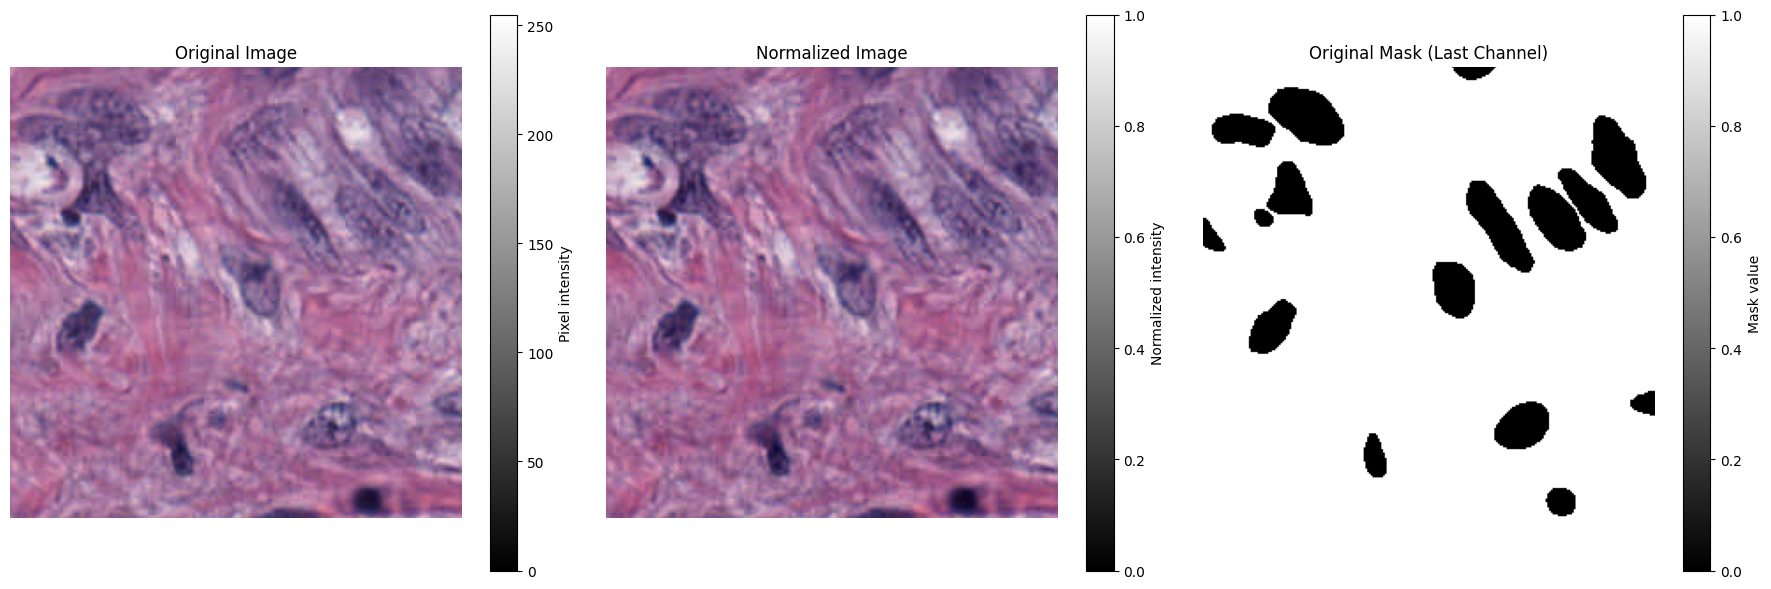

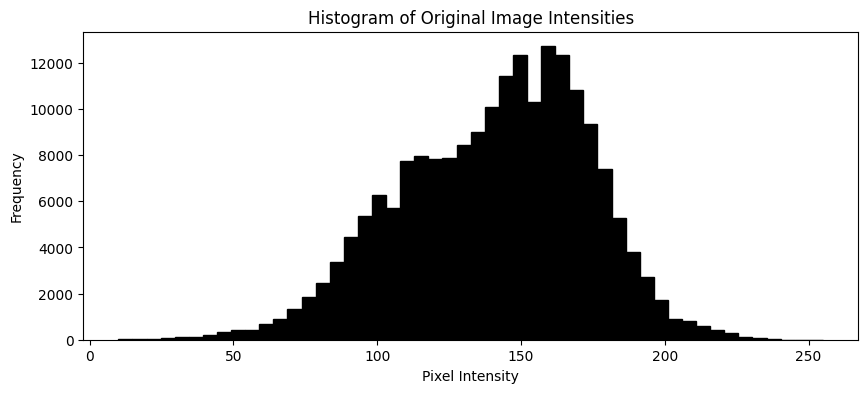

In [110]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_single_sample(dataset, index=0):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean()}")
    print(f"Normalized image - min: {normalized_image.min()}, max: {normalized_image.max()}, mean: {normalized_image.mean()}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    # Plot the original image with adjusted vmin and vmax
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # Display histogram of original image intensities
    plt.figure(figsize=(10, 4))
    plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    plt.title("Histogram of Original Image Intensities")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Visualize the first sample from the training dataset
print("Visualizing first sample from training dataset:")
visualize_single_sample(train_dataset)

Visualizing random samples from training dataset:

Visualiizng sample 3588:
Original image - min: 21.0, max: 255.0, mean: 176.76
Normalized image - min: 0.00, max: 1.00, mean: 0.67


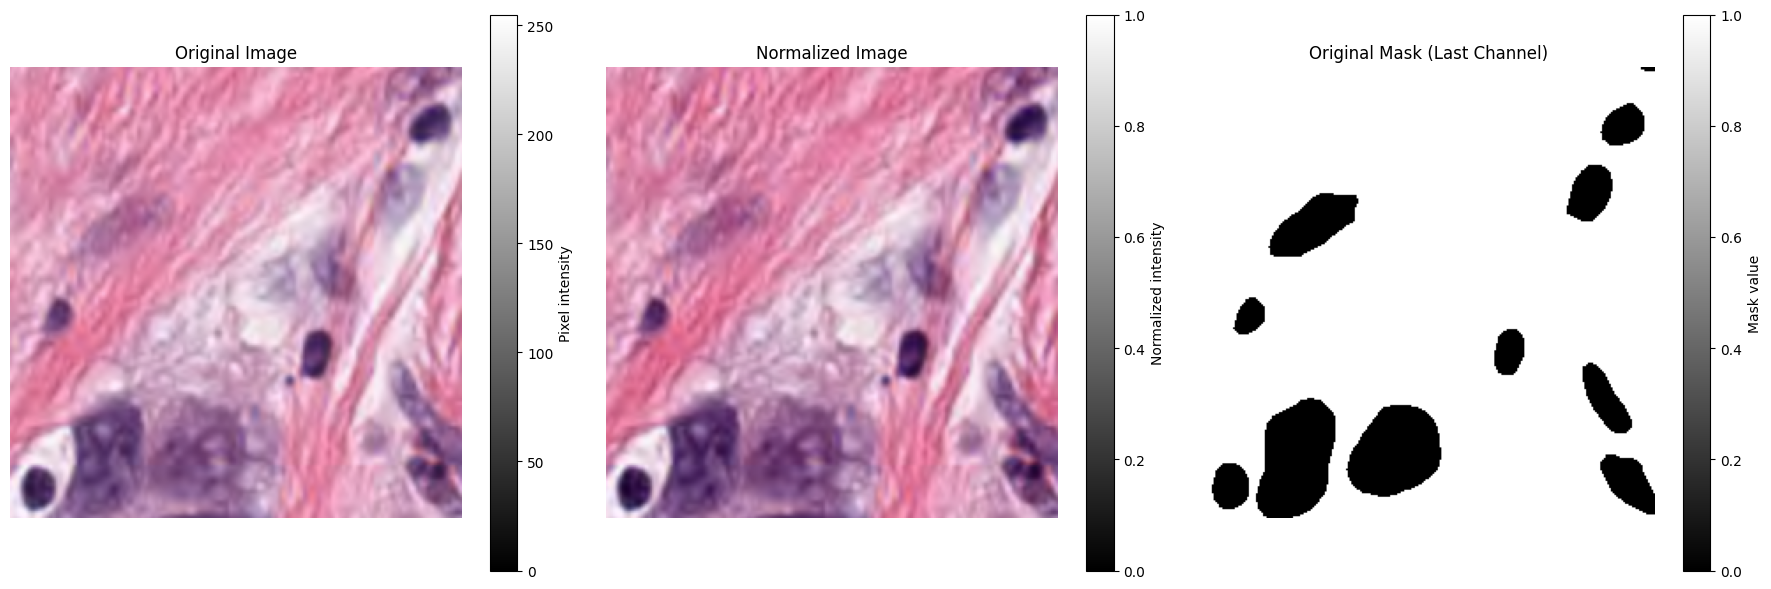


Visualiizng sample 2358:
Original image - min: 2.0, max: 253.0, mean: 174.23
Normalized image - min: 0.00, max: 1.00, mean: 0.69


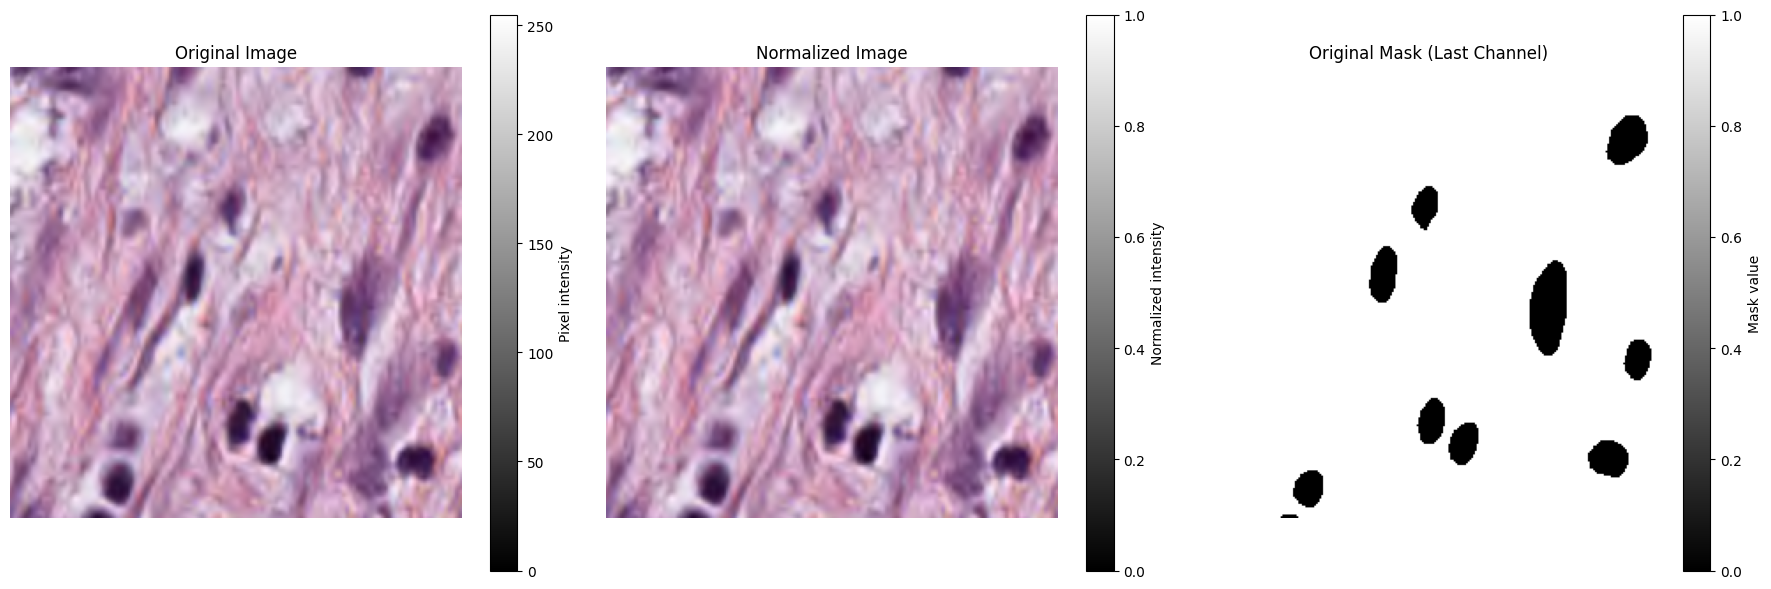


Visualiizng sample 2256:
Original image - min: 0.0, max: 255.0, mean: 149.65
Normalized image - min: 0.00, max: 1.00, mean: 0.59


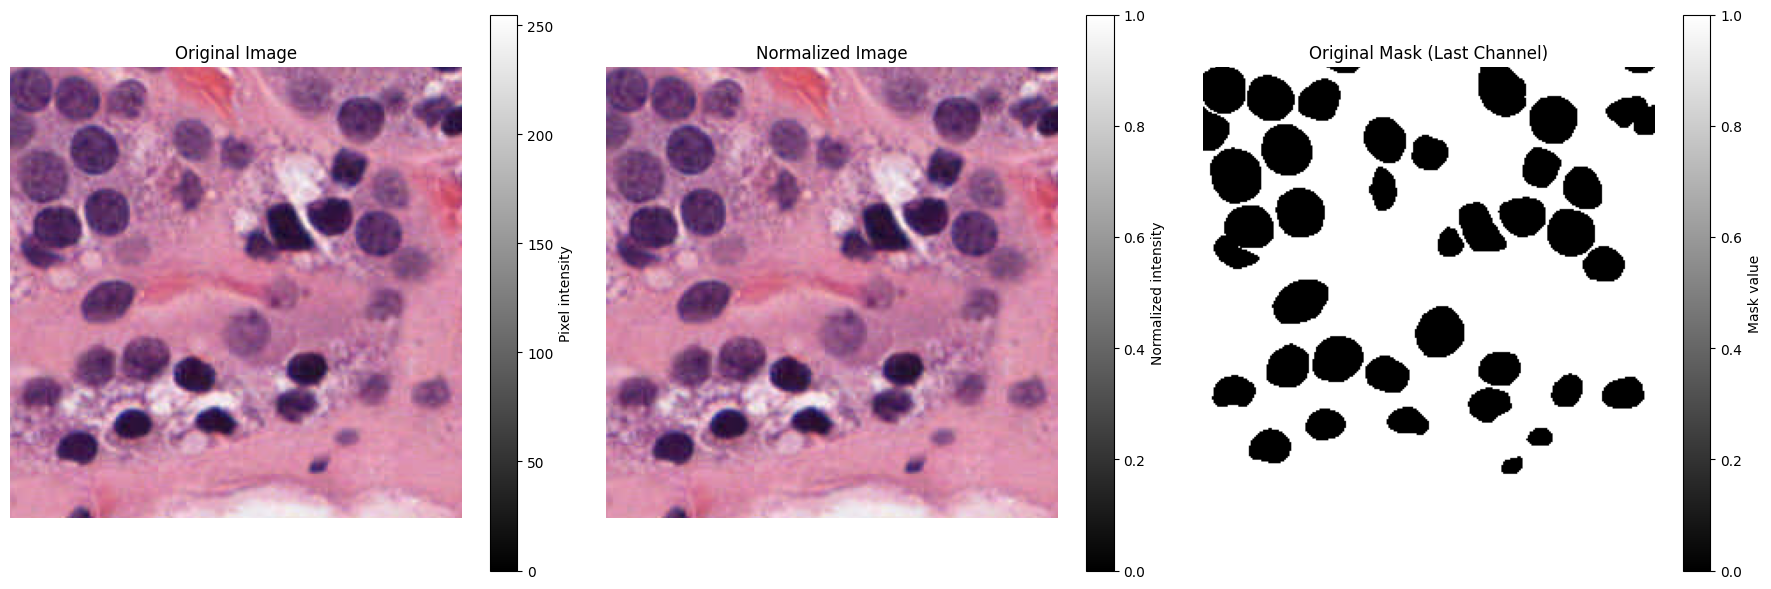

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_random_samples(dataset, num_samples=3):
    # Get the total number of samples in the dataset
    total_samples = len(dataset)
    
    # Generate random indices
    random_indices = random.sample(range(total_samples), num_samples)
    
    for index in random_indices:
        visualize_single_sample(dataset, index)

def visualize_single_sample(dataset, index):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"\nVisualiizng sample {index}:")
    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean():.2f}")
    print(f"Normalized image - min: {normalized_image.min():.2f}, max: {normalized_image.max():.2f}, mean: {normalized_image.mean():.2f}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # # Display histogram of original image intensities
    # plt.figure(figsize=(10, 4))
    # plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    # plt.title(f"Histogram of Original Image Intensities (Sample {index})")
    # plt.xlabel("Pixel Intensity")
    # plt.ylabel("Frequency")
    # plt.show()

# Visualize random samples from the training dataset
print("Visualizing random samples from training dataset:")
visualize_random_samples(train_dataset, num_samples=3)

## model training 

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import swin_t, Swin_T_Weights

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(min(32, out_channels), out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(min(32, out_channels), out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(out_channels, reduction=8)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.residual_conv(x)
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.se(x)
        return x + residual

class SwinEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = Swin_T_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.swin = swin_t(weights=weights)
        self.swin.head = nn.Identity()  # Remove the classifier head

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.swin.features):
            x = layer(x)
            if i in [2, 4, 6]:  # Collect features from specific layers
                features.append(x)
        return features

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(min(32, F_int), F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(min(32, F_int), F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.GroupNorm(1, 1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class FPN(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(FPN, self).__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            for in_channels in in_channels_list
        ])
        self.smooth_convs = nn.ModuleList([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            for _ in in_channels_list
        ])

    def forward(self, features):
        results = []
        last_feature = self.lateral_convs[-1](features[-1])
        results.append(self.smooth_convs[-1](last_feature))

        for i in range(len(features) - 2, -1, -1):
            lateral = self.lateral_convs[i](features[i])
            top_down = F.interpolate(last_feature, scale_factor=2, mode='nearest')
            last_feature = lateral + top_down
            results.insert(0, self.smooth_convs[i](last_feature))

        return results

class UNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fpn = FPN([192, 384, 768], 256)
        self.decoder1 = DecoderBlock(256, 128)
        self.decoder2 = DecoderBlock(128, 64)
        self.decoder3 = DecoderBlock(64, 32)
        self.decoder4 = DecoderBlock(32, 16)
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        fpn_features = self.fpn([f.permute(0, 3, 1, 2) for f in features])
        
        x = self.decoder1(fpn_features[-1])
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.decoder2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.decoder3(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.decoder4(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        x = self.final_conv(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        return self.sigmoid(x)

class CellSwin(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SwinEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

# Initialize the model
model = CellSwin().float()
print("Further improved Swin Transformer-based model defined.")


# Example usage of the combined loss
# criterion = CombinedLoss(weight=0.5)
# loss = criterion(model_output, target)

Further improved Swin Transformer-based model defined.


## New Model

In [113]:
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-5):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, pred, target):
        # Focal Loss
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-bce)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce
        focal_loss = focal_loss.mean()

        # Dice Loss
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return focal_loss + dice
    
    


def iou_score(pred, target, smooth=1e-5, threshold=0.2):
    pred = (pred > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

print("Loss function and metrics defined.")



Loss function and metrics defined.


In [114]:
import numpy as np
from scipy import ndimage

def calculate_object_based_metrics(true_mask, pred_mask, distance_threshold=12):
    def get_centroids(mask):
        mask_np = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
        labeled, num_objects = ndimage.label(mask_np)
        if num_objects == 0:
            return np.array([])
        centroids = ndimage.center_of_mass(mask_np, labeled, range(1, num_objects+1))
        return np.array(centroids)

    true_centroids = get_centroids(true_mask)
    pred_centroids = get_centroids(pred_mask)

    if len(true_centroids) == 0 and len(pred_centroids) == 0:
        return 1.0, 1.0, 1.0  # Perfect score if both are empty
    elif len(true_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false positives
    elif len(pred_centroids) == 0:
        return 0.0, 0.0, 0.0  # All false negatives

    matched = set()
    tp = 0

    for pred_centroid in pred_centroids:
        distances = np.sqrt(((true_centroids - pred_centroid[np.newaxis, :]) ** 2).sum(axis=1))
        if distances.size > 0 and np.min(distances) <= distance_threshold:
            match_idx = np.argmin(distances)
            if match_idx not in matched:
                tp += 1
                matched.add(match_idx)

    fp = len(pred_centroids) - tp
    fn = len(true_centroids) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

## #new 

In [115]:
import torch
from tqdm import tqdm
import os
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_model(model, train_loader, val_loader, num_epochs=100, patience=20, save_dir='models'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = FocalDiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    os.makedirs(save_dir, exist_ok=True)
    best_val_loss = float('inf')
    best_model = None
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for images, masks in train_bar:
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_iou += iou_score(outputs, masks).item()
            
            # Calculate object-based metrics
            pred_masks = (outputs > 0.5).float()
            batch_precision, batch_recall, batch_f1 = 0, 0, 0
            for true_mask, pred_mask in zip(masks, pred_masks):
                p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                batch_precision += p
                batch_recall += r
                batch_f1 += f
            
            train_precision += batch_precision / len(masks)
            train_recall += batch_recall / len(masks)
            train_f1 += batch_f1 / len(masks)
            
            train_bar.set_postfix({
                'loss': f"{loss.item():.4f}", 
                'iou': f"{iou_score(outputs, masks).item():.4f}",
                'precision': f"{batch_precision / len(masks):.4f}",
                'recall': f"{batch_recall / len(masks):.4f}",
                'f1': f"{batch_f1 / len(masks):.4f}"
            })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        avg_train_precision = train_precision / len(train_loader)
        avg_train_recall = train_recall / len(train_loader)
        avg_train_f1 = train_f1 / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_iou = 0
        val_precision = 0
        val_recall = 0
        val_f1 = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += iou_score(outputs, masks).item()
                
                # Calculate object-based metrics
                pred_masks = (outputs > 0.5).float()
                batch_precision, batch_recall, batch_f1 = 0, 0, 0
                for true_mask, pred_mask in zip(masks, pred_masks):
                    p, r, f = calculate_object_based_metrics(true_mask, pred_mask)
                    batch_precision += p
                    batch_recall += r
                    batch_f1 += f
                
                val_precision += batch_precision / len(masks)
                val_recall += batch_recall / len(masks)
                val_f1 += batch_f1 / len(masks)
                
                val_bar.set_postfix({
                    'loss': f"{loss.item():.4f}", 
                    'iou': f"{iou_score(outputs, masks).item():.4f}",
                    'precision': f"{batch_precision / len(masks):.4f}",
                    'recall': f"{batch_recall / len(masks):.4f}",
                    'f1': f"{batch_f1 / len(masks):.4f}"
                })
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_precision = val_precision / len(val_loader)
        avg_val_recall = val_recall / len(val_loader)
        avg_val_f1 = val_f1 / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Train Precision: {avg_train_precision:.4f}, Train Recall: {avg_train_recall:.4f}, Train F1: {avg_train_f1:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Val Precision: {avg_val_precision:.4f}, Val Recall: {avg_val_recall:.4f}, Val F1: {avg_val_f1:.4f}')
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            counter = 0
            save_path = os.path.join(save_dir, 'v3_fold2.pth')
            torch.save(best_model, save_path)
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    model.load_state_dict(best_model)
    return model

print("Updated training function with precision, recall, and F1 score calculations.")

Updated training function with precision, recall, and F1 score calculations.


In [116]:
!pwd

/rsrch5/home/plm/yshokrollahi/vitamin-p/new-vitamin-p


In [ ]:
# Initialize the model
model = CellSwin().float()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=200, patience=50, save_dir='models/')

Epoch 1/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.81it/s, loss=0.1570, iou=0.8107, precision=1.0000, recall=0.5618, f1=0.6356]


Epoch 1/200:
Train Loss: 0.1850, Train IoU: 0.8170, Train Precision: 0.9151, Train Recall: 0.7164, Train F1: 0.7432
Val Loss: 0.1436, Val IoU: 0.8216, Val Precision: 0.9171, Val Recall: 0.5942, Val F1: 0.6493
Saved best model with validation loss: 0.1436


Epoch 2/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.77it/s, loss=0.1523, iou=0.8285, precision=0.8667, recall=0.5118, f1=0.5594]


Epoch 2/200:
Train Loss: 0.1465, Train IoU: 0.8292, Train Precision: 0.8947, Train Recall: 0.7241, Train F1: 0.7389
Val Loss: 0.1283, Val IoU: 0.8451, Val Precision: 0.7812, Val Recall: 0.5740, Val F1: 0.5981
Saved best model with validation loss: 0.1283


Epoch 3/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.60it/s, loss=0.1460, iou=0.8381, precision=0.9000, recall=0.5118, f1=0.5689]


Epoch 3/200:
Train Loss: 0.1374, Train IoU: 0.8377, Train Precision: 0.8961, Train Recall: 0.7317, Train F1: 0.7437
Val Loss: 0.1192, Val IoU: 0.8546, Val Precision: 0.7847, Val Recall: 0.5745, Val F1: 0.6045
Saved best model with validation loss: 0.1192


Epoch 4/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.83it/s, loss=0.1399, iou=0.8479, precision=0.7400, recall=0.5118, f1=0.5455]


Epoch 4/200:
Train Loss: 0.1313, Train IoU: 0.8436, Train Precision: 0.8973, Train Recall: 0.7270, Train F1: 0.7411
Val Loss: 0.1130, Val IoU: 0.8682, Val Precision: 0.7860, Val Recall: 0.5905, Val F1: 0.6129
Saved best model with validation loss: 0.1130


Epoch 5/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.66it/s, loss=0.1304, iou=0.8377, precision=0.8400, recall=0.5118, f1=0.5467]


Epoch 5/200:
Train Loss: 0.1276, Train IoU: 0.8490, Train Precision: 0.8969, Train Recall: 0.7454, Train F1: 0.7550
Val Loss: 0.1040, Val IoU: 0.8662, Val Precision: 0.8862, Val Recall: 0.6113, Val F1: 0.6533
Saved best model with validation loss: 0.1040


Epoch 6/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.85it/s, loss=0.1244, iou=0.8514, precision=0.6800, recall=0.5618, f1=0.5766]


Epoch 6/200:
Train Loss: 0.1245, Train IoU: 0.8514, Train Precision: 0.8930, Train Recall: 0.7385, Train F1: 0.7478
Val Loss: 0.1044, Val IoU: 0.8692, Val Precision: 0.8543, Val Recall: 0.6057, Val F1: 0.6356


Epoch 7/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.92it/s, loss=0.1317, iou=0.8418, precision=0.7667, recall=0.5618, f1=0.6000]


Epoch 7/200:
Train Loss: 0.1233, Train IoU: 0.8519, Train Precision: 0.8971, Train Recall: 0.7462, Train F1: 0.7533
Val Loss: 0.1018, Val IoU: 0.8666, Val Precision: 0.8389, Val Recall: 0.6056, Val F1: 0.6401
Saved best model with validation loss: 0.1018


Epoch 8/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.35it/s, loss=0.1249, iou=0.8570, precision=0.6238, recall=0.5618, f1=0.5594]


Epoch 8/200:
Train Loss: 0.1230, Train IoU: 0.8536, Train Precision: 0.8962, Train Recall: 0.7387, Train F1: 0.7462
Val Loss: 0.1047, Val IoU: 0.8705, Val Precision: 0.8429, Val Recall: 0.6022, Val F1: 0.6375


Epoch 9/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.34it/s, loss=0.1243, iou=0.8567, precision=0.7500, recall=0.5118, f1=0.5511]


Epoch 9/200:
Train Loss: 0.1199, Train IoU: 0.8567, Train Precision: 0.8992, Train Recall: 0.7461, Train F1: 0.7529
Val Loss: 0.0982, Val IoU: 0.8755, Val Precision: 0.8787, Val Recall: 0.6092, Val F1: 0.6511
Saved best model with validation loss: 0.0982


Epoch 10/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.25it/s, loss=0.1221, iou=0.8564, precision=0.8000, recall=0.5118, f1=0.5677]


Epoch 10/200:
Train Loss: 0.1206, Train IoU: 0.8562, Train Precision: 0.8925, Train Recall: 0.7458, Train F1: 0.7501
Val Loss: 0.1023, Val IoU: 0.8705, Val Precision: 0.8814, Val Recall: 0.6005, Val F1: 0.6416


Epoch 11/200 - Validation: 100%|██████████| 33/33 [00:03<00:00,  8.49it/s, loss=0.1310, iou=0.8576, precision=0.7000, recall=0.4735, f1=0.5088]


Epoch 11/200:
Train Loss: 0.1171, Train IoU: 0.8588, Train Precision: 0.9015, Train Recall: 0.7453, Train F1: 0.7548
Val Loss: 0.0993, Val IoU: 0.8740, Val Precision: 0.8102, Val Recall: 0.5980, Val F1: 0.6236


Epoch 12/200 - Validation: 100%|██████████| 33/33 [00:04<00:00,  8.18it/s, loss=0.1211, iou=0.8393, precision=1.0000, recall=0.5118, f1=0.5822]


Epoch 12/200:
Train Loss: 0.1173, Train IoU: 0.8586, Train Precision: 0.8993, Train Recall: 0.7470, Train F1: 0.7532
Val Loss: 0.0970, Val IoU: 0.8615, Val Precision: 0.9277, Val Recall: 0.6108, Val F1: 0.6617
Saved best model with validation loss: 0.0970


Epoch 13/200 - Training:  14%|█▍        | 42/292 [00:09<00:46,  5.36it/s, loss=0.1437, iou=0.8292, precision=0.8438, recall=0.6667, f1=0.7054]

## load the model

In [22]:
import torch

# Path to your saved model
model_path = 'models/v3.pth'

# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model architecture
trained_model = CellSwin().float()

# Load the saved state dict
state_dict = torch.load(model_path, map_location=device)

# Load the state dict into your model
trained_model.load_state_dict(state_dict)

# Move the model to the appropriate device
trained_model = trained_model.to(device)

# Set the model to evaluation mode
trained_model.eval()

print(f"Model loaded successfully and moved to {device}!")

Model loaded successfully and moved to cuda!


In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import random

def visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3):
    model.eval()
    
    # Randomly select indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    overall_f1 = 0
    overall_precision = 0
    overall_recall = 0
    
    for i, idx in enumerate(indices):
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            output = model(image)
        
        image = image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
        mask = mask.cpu().numpy().squeeze()
        output = output.cpu().numpy().squeeze()
        
        # Calculate metrics
        pred_mask = (output > 0.5).astype(np.uint8)
        f1 = f1_score(mask.flatten(), pred_mask.flatten(), average='binary')
        precision = precision_score(mask.flatten(), pred_mask.flatten(), average='binary')
        recall = recall_score(mask.flatten(), pred_mask.flatten(), average='binary')
        
        overall_f1 += f1
        overall_precision += precision
        overall_recall += recall
        
        # Plotting
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Input Image {idx}")
        axes[i, 0].axis('off')
        
        # Use a custom colormap for true mask
        axes[i, 1].imshow(mask, cmap='gray_r', vmin=0, vmax=1)
        axes[i, 1].set_title(f"True Mask {idx}")
        axes[i, 1].axis('off')
        
        # Use a custom colormap for predicted mask
        axes[i, 2].imshow(pred_mask, cmap='gray_r', vmin=0, vmax=1)
        axes[i, 2].set_title(f"Predicted Mask {idx}\nF1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print overall metrics
    overall_f1 /= num_samples
    overall_precision /= num_samples
    overall_recall /= num_samples
    
    print(f"Overall Metrics (average of {num_samples} samples):")
    print(f"F1 Score: {overall_f1:.4f}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall: {overall_recall:.4f}")



In [94]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import f1_score, precision_score, recall_score
# import torch

# def visualize_prediction_with_metrics(model, test_dataset, device):
#     model.eval()
    
#     # Use the first three images
#     indices = [0, 1, 2]
#     num_samples = len(indices)
    
#     fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
#     overall_f1 = 0
#     overall_precision = 0
#     overall_recall = 0
    
#     for i, idx in enumerate(indices):
#         image, mask = test_dataset[idx]
#         image = image.unsqueeze(0).to(device)  # Add batch dimension
        
#         with torch.no_grad():
#             output = model(image)
        
#         image = image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
#         mask = mask.cpu().numpy().squeeze()
#         output = output.cpu().numpy().squeeze()
        
#         # Calculate metrics
#         pred_mask = (output > 0.5).astype(np.uint8)
#         f1 = f1_score(mask.flatten(), pred_mask.flatten(), average='binary')
#         precision = precision_score(mask.flatten(), pred_mask.flatten(), average='binary')
#         recall = recall_score(mask.flatten(), pred_mask.flatten(), average='binary')
        
#         overall_f1 += f1
#         overall_precision += precision
#         overall_recall += recall
        
#         # Plotting
#         axes[i, 0].imshow(image)
#         axes[i, 0].set_title(f"Input Image {idx}")
#         axes[i, 0].axis('off')
        
#         axes[i, 1].imshow(mask, cmap='gray')
#         axes[i, 1].set_title(f"True Mask {idx}")
#         axes[i, 1].axis('off')
        
#         axes[i, 2].imshow(pred_mask, cmap='gray')
#         axes[i, 2].set_title(f"Predicted Mask {idx}\nF1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
#         axes[i, 2].axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
#     # Calculate and print overall metrics
#     overall_f1 /= num_samples
#     overall_precision /= num_samples
#     overall_recall /= num_samples
    
#     print(f"Overall Metrics (average of {num_samples} samples):")
#     print(f"F1 Score: {overall_f1:.4f}")
#     print(f"Precision: {overall_precision:.4f}")
#     print(f"Recall: {overall_recall:.4f}")

# # Usage
# model = trained_model  # Your trained CellViT model
# test_dataset = CellSegmentationDataset(
#     data_splits[chosen_split]['test']['images'],
#     data_splits[chosen_split]['test']['masks'],
#     image_transform=image_transform,
#     mask_transform=mask_transform
# )
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Call the function to visualize the first three images
# visualize_prediction_with_metrics(model, test_dataset, device)

2722


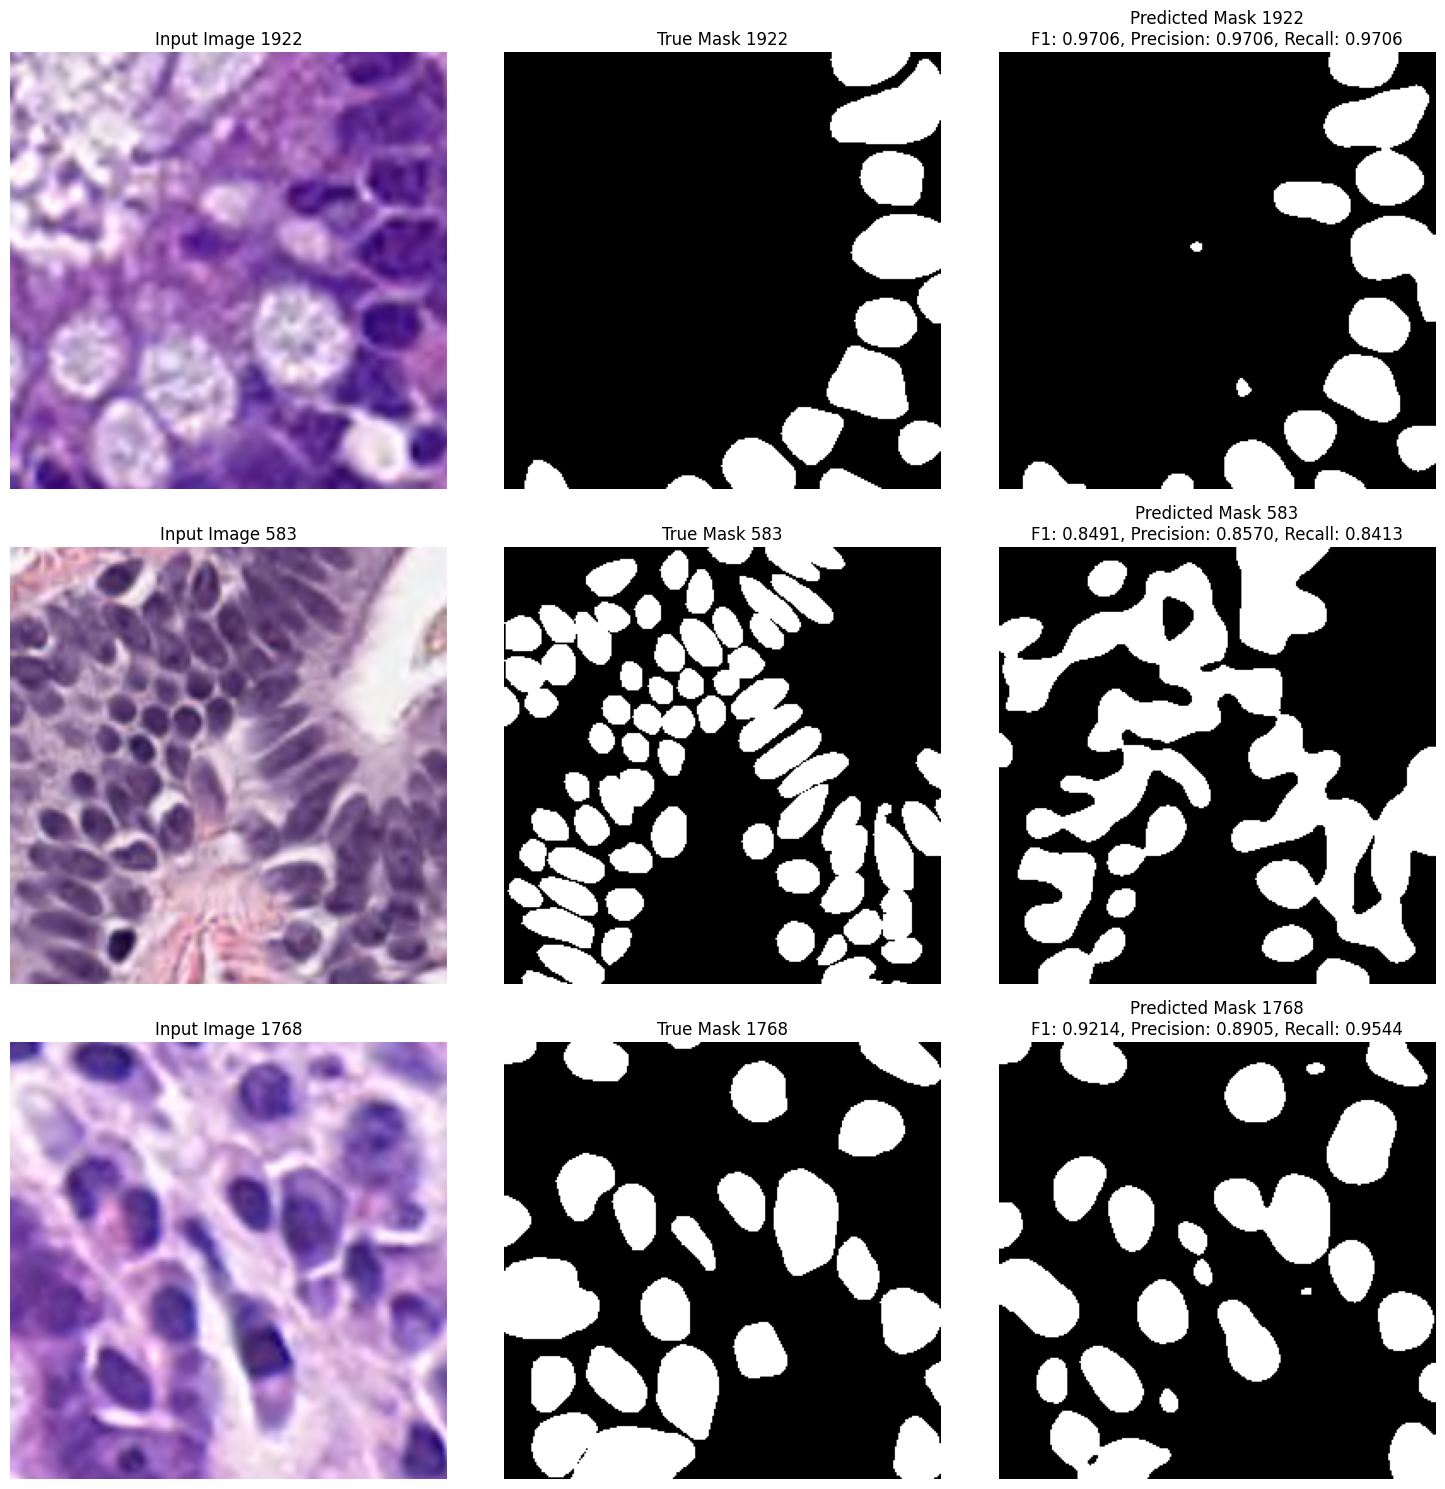

Overall Metrics (average of 3 samples):
F1 Score: 0.9137
Precision: 0.9061
Recall: 0.9221


In [99]:
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_test_images = len(test_dataset)
print(num_test_images)
# Visualize and calculate metrics
visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3)

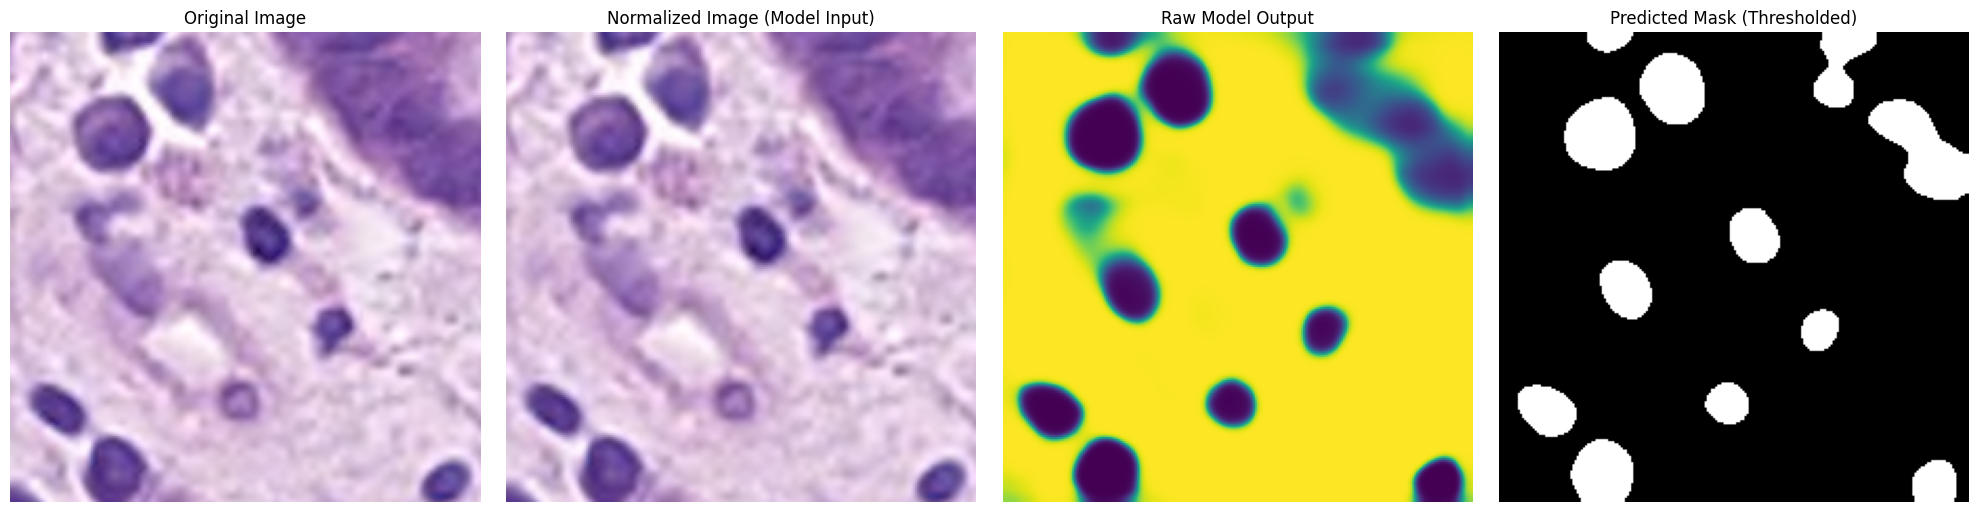

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms

def visualize_prediction_with_original(model, image_path, device, image_transform):
    model.eval()
    
    # Load the original image
    original_image = Image.open(image_path)
    
    # Apply transforms and convert to tensor
    transformed_image = image_transform(original_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(transformed_image)
    
    # Convert tensors to numpy arrays
    original_np = np.array(original_image)
    transformed_np = transformed_image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
    output_np = output.cpu().numpy().squeeze()
    
    # Generate predicted mask
    pred_mask = (output_np > 0.3).astype(np.uint8)
    
    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(original_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Denormalize the transformed image for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    denormalized = transformed_np * std + mean
    denormalized = np.clip(denormalized, 0, 1)
    
    axes[1].imshow(denormalized)
    axes[1].set_title("Normalized Image (Model Input)")
    axes[1].axis('off')
    
    axes[2].imshow(output_np, cmap='viridis')
    axes[2].set_title("Raw Model Output")
    axes[2].axis('off')
    
    axes[3].imshow(pred_mask, cmap='gray_r', vmin=0, vmax=1)
    axes[3].set_title("Predicted Mask (Thresholded)")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
model = trained_model  # Your trained CellViT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define image transform (make sure this matches your training transform)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to your static image
image_path = "/rsrch5/home/plm/yshokrollahi/CellViT/configs/datasets/reassemble/fold2/images/2_1825.png"

# Visualize prediction
visualize_prediction_with_original(model, image_path, device, image_transform)

## new metrics

In [49]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from skimage import measure  # Add this line

def pair_coordinates(true_centroids, pred_centroids, pairing_radius):
    if len(true_centroids) == 0 or len(pred_centroids) == 0:
        return np.array([]), np.arange(len(true_centroids)), np.arange(len(pred_centroids))
    
    # Ensure we're only using x and y coordinates
    true_centroids = true_centroids[:, :2]
    pred_centroids = pred_centroids[:, :2]
    
    distances = np.linalg.norm(true_centroids[:, None] - pred_centroids[None, :], axis=-1)
    true_indices, pred_indices = linear_sum_assignment(distances)
    
    paired = []
    unpaired_true = []
    unpaired_pred = []
    
    for true_idx, pred_idx in zip(true_indices, pred_indices):
        if distances[true_idx, pred_idx] <= pairing_radius:
            paired.append((true_idx, pred_idx))
        else:
            unpaired_true.append(true_idx)
            unpaired_pred.append(pred_idx)
    
    return np.array(paired), np.array(unpaired_true), np.array(unpaired_pred)

def calculate_instance_map(binary_mask):
    from skimage import measure
    return measure.label(binary_mask)

def get_centroids(instance_map):
    props = measure.regionprops(instance_map)
    centroids = np.array([prop.centroid for prop in props])
    if centroids.size == 0:
        return np.empty((0, 2))  # Return empty 2D array if no centroids
    elif centroids.ndim == 1:
        return centroids.reshape(1, -1)  # Single centroid, reshape to 2D
    else:
        return centroids[:, :2]  # Return only x and y coordinates for 3D centroids

def cell_detection_scores(paired_true, paired_pred, unpaired_true, unpaired_pred):
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1, precision, recall

def calculate_metrics_across_all_test_sets(model, test_dataset, device, batch_size=32, pairing_radius=12):
    model.eval()
    
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    paired_all_global = []
    unpaired_true_all_global = []
    unpaired_pred_all_global = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            if images.dim() == 3:
                images = images.unsqueeze(1)
            
            if images.shape[-2:] != (224, 224):
                images = torch.nn.functional.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            if pred_masks.shape[-2:] != masks.shape[-2:]:
                pred_masks = torch.nn.functional.interpolate(pred_masks, size=masks.shape[-2:], mode='nearest')
            
            for true_mask, pred_mask in zip(masks.cpu().numpy(), pred_masks.cpu().numpy()):
                true_instance_map = calculate_instance_map(true_mask)
                pred_instance_map = calculate_instance_map(pred_mask)
                
                true_centroids = get_centroids(true_instance_map)
                pred_centroids = get_centroids(pred_instance_map)
                
                paired, unpaired_true, unpaired_pred = pair_coordinates(true_centroids, pred_centroids, pairing_radius)
                
                paired_all_global.extend(paired.flatten())
                unpaired_true_all_global.extend(unpaired_true.flatten())
                unpaired_pred_all_global.extend(unpaired_pred.flatten())

    paired_all = np.array(paired_all_global).reshape(-1, 2)
    unpaired_true_all = np.array(unpaired_true_all_global)
    unpaired_pred_all = np.array(unpaired_pred_all_global)
    
    f1, precision, recall = cell_detection_scores(
        paired_true=paired_all[:, 0],
        paired_pred=paired_all[:, 1],
        unpaired_true=unpaired_true_all,
        unpaired_pred=unpaired_pred_all
    )
    
    print("Metrics across all test sets:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return f1, precision, recall

# Usage
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Calculate metrics across all test sets
f1, precision, recall = calculate_metrics_across_all_test_sets(model, test_dataset, device)


Evaluating: 100%|██████████| 86/86 [00:15<00:00,  5.70it/s]

Metrics across all test sets:
F1 Score: 0.8890
Precision: 0.8883
Recall: 0.8897
